In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import random
import pickle
from pathlib import Path
from muon import SingleDeviceMuonWithAuxAdam


torch.manual_seed(11)
np.random.seed(11)
random.seed(11)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [26]:
DATA_NUM = 16000
CLUSTER_NUM = 4
EXPERT_NUM = 8
PATCH_NUM = 4
PATCH_LEN = 50

root = Path("synthetic_data_s1")
training_data = torch.load(root / "train_data.pt").to(device)
training_labels = torch.load(root / "train_labels.pt").to(device)
test_data = torch.load(root / "test_data.pt").to(device)
test_labels = torch.load(root / "test_labels.pt").to(device)

centers = torch.load(root / "centers.pt").to(device)
features = torch.load(root / "features.pt").to(device)

with open(root / "train_cluster", "rb") as fp:
    train_cluster_idx = pickle.load(fp)

with open(root / "test_cluster", "rb") as fp:
    test_cluster_idx = pickle.load(fp)

print(f"train: {training_data.shape}, test: {test_data.shape}")

train: torch.Size([16000, 1, 200]), test: torch.Size([16000, 1, 200])


In [27]:
def entropy(dispatch):
    n_expert = torch.sum(dispatch, dim=0)
    n_total = torch.sum(dispatch)
    prob = dispatch / n_expert
    ent = -torch.nansum(prob * torch.log(prob), dim=0)
    return torch.sum((n_expert / n_total) * ent)


def top1(t):
    values, index = t.topk(k=1, dim=-1)
    values, index = map(lambda x: x.squeeze(dim=-1), (values, index))
    return values, index

In [28]:
class ConvNet(nn.Module):
    def __init__(self, input_dim, out_channel, patch_num, small=True, nonlinear=True):
        super().__init__()
        self.conv1 = nn.Conv1d(1, out_channel * 2, int(input_dim / patch_num), int(input_dim / patch_num))
        if small:
            self.conv1.weight = nn.Parameter(self.conv1.weight * 0.001)
            self.conv1.bias = nn.Parameter(self.conv1.bias * 0.001)
        self.out_channel = out_channel
        self.nonlinear = nonlinear

    def forward(self, x):
        x = self.conv1(x)
        if self.nonlinear:
            x = x ** 3
        x = torch.sum(x, 2)
        output = torch.stack(
            [torch.sum(x[:, : self.out_channel], 1), torch.sum(x[:, self.out_channel :], 1)]
        ).transpose(1, 0)
        return output


class Router(nn.Module):
    def __init__(self, input_dim, out_dim, patch_num, noise=True):
        super().__init__()
        self.conv1 = nn.Conv1d(1, out_dim, int(input_dim / patch_num), int(input_dim / patch_num), bias=False)
        self.out_dim = out_dim
        self.noise = noise
        self.break_tie_noise = torch.normal(0, 1e-5, size=(DATA_NUM, out_dim), device=device)
        self.reset_parameters()

    def reset_parameters(self):
        self.conv1.weight = nn.Parameter(self.conv1.weight * 0)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.sum(x, 2)
        if self.noise and self.training:
            return x + torch.rand(DATA_NUM, self.out_dim, device=device)
        if self.training:
            return x + self.break_tie_noise
        return x


class MoE(nn.Module):
    def __init__(self, input_dim, out_channel, patch_num, expert_num, strategy="top1", nonlinear=True):
        super().__init__()
        self.router = Router(input_dim, expert_num, patch_num)
        self.models = nn.ModuleList(
            [ConvNet(input_dim, out_channel, patch_num, nonlinear=nonlinear) for _ in range(expert_num)]
        )
        self.strategy = strategy
        self.expert_num = expert_num

    def forward(self, x):
        select = self.router(x)
        if self.strategy == "top1":
            gate, index = top1(select)
        else:
            raise NotImplementedError("Only top1 is supported in this notebook.")

        mask = F.one_hot(index, self.expert_num).float()
        density = mask.mean(dim=-2)
        density_proxy = select.mean(dim=-2)
        loss = (density_proxy * density).mean() * float(self.expert_num ** 2)

        mask_flat = mask.sum(dim=-1)
        combine_tensor = (
            gate[..., None, None]
            * mask_flat[..., None, None]
            * F.one_hot(index, self.expert_num)[..., None]
        )
        dispatch_tensor = combine_tensor.bool().to(combine_tensor)
        expert_inputs = torch.einsum("bnd,ben->ebd", x, dispatch_tensor).unsqueeze(2)

        outputs = []
        for i in range(self.expert_num):
            outputs.append(self.models[i](expert_inputs[i]))

        outputs = torch.stack(outputs)
        outputs = torch.einsum("ijk,jil->il", combine_tensor, outputs)
        outputs = F.softmax(outputs, dim=1)
        return outputs, dispatch_tensor, loss

In [29]:
def train(model, criterion, data, labels, optimizers, epochs, load_balancing=True, verbose=True):
    entropy_record = []
    min_loss = float("inf")
    last_select = None

    for epoch in range(epochs):
        for opt in optimizers:
            opt.zero_grad()

        outputs, select0, load_balancing_loss = model(data)
        last_select = select0

        counts = torch.stack(
            [select0[train_cluster_idx[i]].squeeze(-1).sum(dim=0) for i in range(CLUSTER_NUM)]
        )
        e = entropy(counts)
        entropy_record.append(e)

        loss = criterion(outputs, labels)
        if load_balancing:
            loss = loss + 0.0001 * load_balancing_loss

        if loss.item() <= min_loss:
            min_loss = loss.item()
        elif loss > min_loss + 0.02:
            pass

        loss.backward()
        for opt in optimizers:
            opt.step()

        if verbose and epoch % 100 == 0:
            print(f"epoch {epoch}: loss={loss.item():.4f}, entropy={e.item():.4f}")

    print("Finished Training")
    return entropy_record, last_select


In [30]:
def make_muon_param_groups(model, lr_muon=0.02, lr_aux=3e-4, weight_decay=0.01, include_router_in_aux=True):
    expert_weights = [m.conv1.weight for m in model.models if m.conv1.weight.requires_grad]
    aux_params = [m.conv1.bias for m in model.models if m.conv1.bias is not None and m.conv1.bias.requires_grad]
    if include_router_in_aux and model.router.conv1.weight.requires_grad:
        aux_params.append(model.router.conv1.weight)

    groups = []
    if expert_weights:
        groups.append(dict(params=expert_weights, use_muon=True, lr=lr_muon, weight_decay=weight_decay))
    if aux_params:
        groups.append(dict(params=aux_params, use_muon=False, lr=lr_aux, betas=(0.9, 0.95), weight_decay=weight_decay))
    if not groups:
        raise ValueError('No trainable parameters found for Muon/aux groups.')
    return groups


In [32]:
num_epochs = 601

# Option A: Muon on expert conv weights, AdamW (aux) on expert biases + router weights in one optimizer
model = MoE(200, 8, PATCH_NUM, EXPERT_NUM, strategy="top1", nonlinear=True).to(device)
criterion = torch.nn.CrossEntropyLoss()
opt_muon = SingleDeviceMuonWithAuxAdam(make_muon_param_groups(model))
entropy_record, select0 = train(
    model,
    criterion,
    training_data,
    training_labels,
    [opt_muon],
    num_epochs,
    load_balancing=True,
    verbose=True,
)

print_dispatch(select0)
test(model, criterion, training_data, training_labels, name="train")
test(model, criterion, test_data, test_labels, name="test")

epoch 0: loss=0.6935, entropy=1.3859
epoch 100: loss=0.4847, entropy=1.1620
epoch 200: loss=0.4664, entropy=1.0873
epoch 300: loss=0.4589, entropy=1.0548
epoch 400: loss=0.4605, entropy=1.0330
epoch 500: loss=0.4634, entropy=1.0459
epoch 600: loss=0.4497, entropy=1.0581
Finished Training
Overall dispatch counts: tensor([  48, 5080, 2217,  896, 2486, 4237,  843,  193])
cluster 0: tensor([   1, 1221,  353,  129,  324, 1986,    7,   14])
cluster 1: tensor([  36,  168, 1778,  322,  193, 1007,  495,    0])
cluster 2: tensor([   3, 1398,   69,   64,  946, 1199,  297,   30])
cluster 3: tensor([   8, 2293,   17,  381, 1023,   45,   44,  149])
Accuracy on train (16000 samples): 86.4875%
Accuracy on test (16000 samples): 87.0563%


87.05625

### Flat expert weights for Muon
Flatten experts' conv filters into 2D matrices so Muon can orthogonalize them.

In [47]:
class FlatConvNet(nn.Module):
    def __init__(self, input_dim, out_channel, patch_num, small=True, nonlinear=True):
        super().__init__()
        self.out_channel = out_channel
        self.patch_len = int(input_dim / patch_num)
        self.weight_flat = nn.Parameter(torch.empty(out_channel * 2, self.patch_len))
        self.bias = nn.Parameter(torch.zeros(out_channel * 2))
        if small:
            nn.init.uniform_(self.weight_flat, -1e-3, 1e-3)
            nn.init.uniform_(self.bias, -1e-3, 1e-3)
        else:
            nn.init.xavier_uniform_(self.weight_flat)
            nn.init.zeros_(self.bias)
        self.nonlinear = nonlinear

    def forward(self, x):
        w = self.weight_flat.view(self.out_channel * 2, 1, self.patch_len)
        x = F.conv1d(x, w, bias=self.bias, stride=self.patch_len)
        if self.nonlinear:
            x = x ** 3
        x = torch.sum(x, 2)
        output = torch.stack([
            torch.sum(x[:, : self.out_channel], 1),
            torch.sum(x[:, self.out_channel :], 1),
        ]).transpose(1, 0)
        return output


class FlatMoE(nn.Module):
    def __init__(self, input_dim, out_channel, patch_num, expert_num, strategy="top1", nonlinear=True):
        super().__init__()
        self.router = Router(input_dim, expert_num, patch_num)
        self.models = nn.ModuleList(
            [FlatConvNet(input_dim, out_channel, patch_num, nonlinear=nonlinear) for _ in range(expert_num)]
        )
        self.strategy = strategy
        self.expert_num = expert_num

    def forward(self, x):
        select = self.router(x)
        if self.strategy == "top1":
            gate, index = top1(select)
        else:
            raise NotImplementedError("Only top1 is supported in this notebook.")

        mask = F.one_hot(index, self.expert_num).float()
        density = mask.mean(dim=-2)
        density_proxy = select.mean(dim=-2)
        loss = (density_proxy * density).mean() * float(self.expert_num ** 2)

        mask_flat = mask.sum(dim=-1)
        combine_tensor = (
            gate[..., None, None]
            * mask_flat[..., None, None]
            * F.one_hot(index, self.expert_num)[..., None]
        )
        dispatch_tensor = combine_tensor.bool().to(combine_tensor)
        expert_inputs = torch.einsum("bnd,ben->ebd", x, dispatch_tensor).unsqueeze(2)

        outputs = []
        for i in range(self.expert_num):
            outputs.append(self.models[i](expert_inputs[i]))

        outputs = torch.stack(outputs)
        outputs = torch.einsum("ijk,jil->il", combine_tensor, outputs)
        outputs = F.softmax(outputs, dim=1)
        return outputs, dispatch_tensor, loss


def make_flat_muon_param_groups(model, lr_muon=1e-4, lr_aux=3e-4, weight_decay=0.01, include_router_in_aux=True):
    expert_weights = [m.weight_flat for m in model.models if m.weight_flat.requires_grad]
    aux_params = [m.bias for m in model.models if m.bias is not None and m.bias.requires_grad]
    if include_router_in_aux and model.router.conv1.weight.requires_grad:
        aux_params.append(model.router.conv1.weight)
    groups = []
    if expert_weights:
        groups.append(dict(params=expert_weights, use_muon=True, lr=lr_muon, weight_decay=weight_decay))
    if aux_params:
        groups.append(dict(params=aux_params, use_muon=False, lr=lr_aux, betas=(0.9, 0.95), weight_decay=weight_decay))
    if not groups:
        raise ValueError('No trainable parameters found for Muon/aux groups.')
    return groups


In [48]:
# Option C: Flatten expert filters to 2D matrices before Muon
num_epochs = 601
flat_model = FlatMoE(200, 8, PATCH_NUM, EXPERT_NUM, strategy="top1", nonlinear=True).to(device)
criterion = torch.nn.CrossEntropyLoss()
opt_flat_muon = SingleDeviceMuonWithAuxAdam(make_flat_muon_param_groups(flat_model))
entropy_record, select0 = train(
    flat_model,
    criterion,
    training_data,
    training_labels,
    [opt_flat_muon],
    num_epochs,
    load_balancing=True,
    verbose=True,
)
print_dispatch(select0)
test(flat_model, criterion, training_data, training_labels, name="train")
test(flat_model, criterion, test_data, test_labels, name="test")


epoch 0: loss=0.6935, entropy=1.3853
epoch 100: loss=0.6894, entropy=1.2492
epoch 200: loss=0.6157, entropy=0.9963
epoch 300: loss=0.5104, entropy=0.8487
epoch 400: loss=0.4392, entropy=0.7619
epoch 500: loss=0.4057, entropy=0.8015
epoch 600: loss=0.3828, entropy=0.8515
Finished Training
Overall dispatch counts: tensor([2255,  651,  917, 1122, 3459, 1604, 4176, 1816])
cluster 0: tensor([ 381,    2,    3,   10,  537,   58, 1411, 1633])
cluster 1: tensor([ 393,   15,    1,    2,  281, 1528, 1672,  107])
cluster 2: tensor([1047,    0,  908,   55, 1011,   12,  912,   61])
cluster 3: tensor([ 434,  634,    5, 1055, 1630,    6,  181,   15])
Accuracy on train (16000 samples): 92.8688%
Accuracy on test (16000 samples): 92.1813%


92.18125

In [49]:
num_epochs = 601

flat_model = FlatMoE(200, 8, PATCH_NUM, EXPERT_NUM, strategy="top1", nonlinear=True).to(device)
criterion = torch.nn.CrossEntropyLoss()

opt_flat_adamw = torch.optim.AdamW(
    flat_model.parameters(), lr=1e-4, betas=(0.9, 0.95), weight_decay=0.01
)

entropy_record, select0 = train(
    flat_model,
    criterion,
    training_data,
    training_labels,
    [opt_flat_adamw],   # only AdamW optimizer
    num_epochs,
    load_balancing=True,
    verbose=True,
)

print_dispatch(select0)
test(flat_model, criterion, training_data, training_labels, name="train-adamw")
test(flat_model, criterion, test_data, test_labels, name="test-adamw")


epoch 0: loss=0.6935, entropy=1.3854
epoch 100: loss=0.4819, entropy=0.9191
epoch 200: loss=0.3537, entropy=0.5482
epoch 300: loss=0.3429, entropy=0.6933
epoch 400: loss=0.3539, entropy=0.9264
epoch 500: loss=0.3644, entropy=1.0911
epoch 600: loss=0.3629, entropy=1.1627
Finished Training
Overall dispatch counts: tensor([2749,  114, 3044,  894,   56, 4351, 1451, 3341])
cluster 0: tensor([ 379,    0,  665,    3,    0, 2037,    6,  945])
cluster 1: tensor([ 120,    0,  611,  653,    0,  518, 1226,  871])
cluster 2: tensor([ 797,  114,  869,   36,    0, 1083,  203,  904])
cluster 3: tensor([1453,    0,  899,  202,   56,  713,   16,  621])
Accuracy on train-adamw (16000 samples): 95.3187%
Accuracy on test-adamw (16000 samples): 94.9562%


94.95625

### Compare Muon (flat experts) vs AdamW
Runs flat-parameter MoE with Muon+aux AdamW vs all-AdamW and plots test accuracy + dispatch entropy.


Finished Training
Accuracy on train-muon (16000 samples): 88.5625%
Accuracy on test-muon (16000 samples): 87.8375%
Finished Training
Accuracy on train-adamw (16000 samples): 97.5500%
Accuracy on test-adamw (16000 samples): 96.8438%


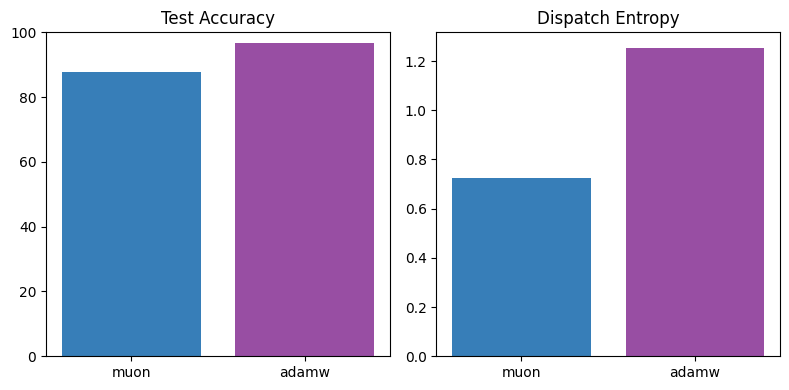

In [52]:
import matplotlib.pyplot as plt

def run_flat(mode, epochs=400):
    torch.manual_seed(11); np.random.seed(11); random.seed(11)
    model = FlatMoE(200, 8, PATCH_NUM, EXPERT_NUM, strategy="top1", nonlinear=True).to(device)
    crit = torch.nn.CrossEntropyLoss()
    if mode == "muon":
        opt = SingleDeviceMuonWithAuxAdam(make_flat_muon_param_groups(model, include_router_in_aux=True))
        opt_list = [opt]
    elif mode == "adamw":
        opt = torch.optim.AdamW(model.parameters(), lr=3e-4, betas=(0.9, 0.95), weight_decay=0.01)
        opt_list = [opt]
    else:
        raise ValueError(mode)

    entropy_record, select0 = train(model, crit, training_data, training_labels,
                                    opt_list, epochs, load_balancing=True, verbose=False)
    train_acc = test(model, crit, training_data, training_labels, name=f"train-{mode}")
    test_acc = test(model, crit, test_data, test_labels, name=f"test-{mode}")
    return dict(mode=mode, train_acc=train_acc, test_acc=test_acc,
                entropy=entropy_record[-1].item(), select0=select0)

results = [run_flat(m, epochs=400) for m in ["muon", "adamw"]]
modes = [r["mode"] for r in results]
test_acc = [r["test_acc"] for r in results]
entropy_vals = [r["entropy"] for r in results]

fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].bar(modes, test_acc, color=["#377eb8", "#984ea3", "#4daf4a"])
ax[0].set_title("Test Accuracy"); ax[0].set_ylim(0, 100)
ax[1].bar(modes, entropy_vals, color=["#377eb8", "#984ea3", "#4daf4a"])
ax[1].set_title("Dispatch Entropy")
plt.tight_layout(); plt.show()
